In [1]:
import pickle 
import json
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import torch

from mlflux.predictor import FluxANNs
from mlflux.ann import RealFluxDataset
from mlflux.eval import mse_r2_weighted, distribution_weighted, open_case, evaluate
from mlflux.datafunc import data_split_psd_rand

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 3

### Uncertainty structure

In [6]:
# "U", "tsea", "tair", "zu", "zt"
# from mlflux.utils import qsat
from probes import gen_grid_U_dT, gen_grid_U_RH, plot_data_density_U_dT, plot_data_density_U_RH

/scratch/jw8736/mlflux/notebooks/regression/probes.py:79: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/scratch/jw8736/mlflux/notebooks/regression/probes.py:79: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/scratch/jw8736/mlflux/notebooks/regression/probes.py:79: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/scratch/jw8736/mlflux/notebooks/regression/probes.py:79: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/scratch/jw8736/mlflux/notebooks/regression/probes.py:79: UserWarning: The following kwargs were not used by contour: 'f

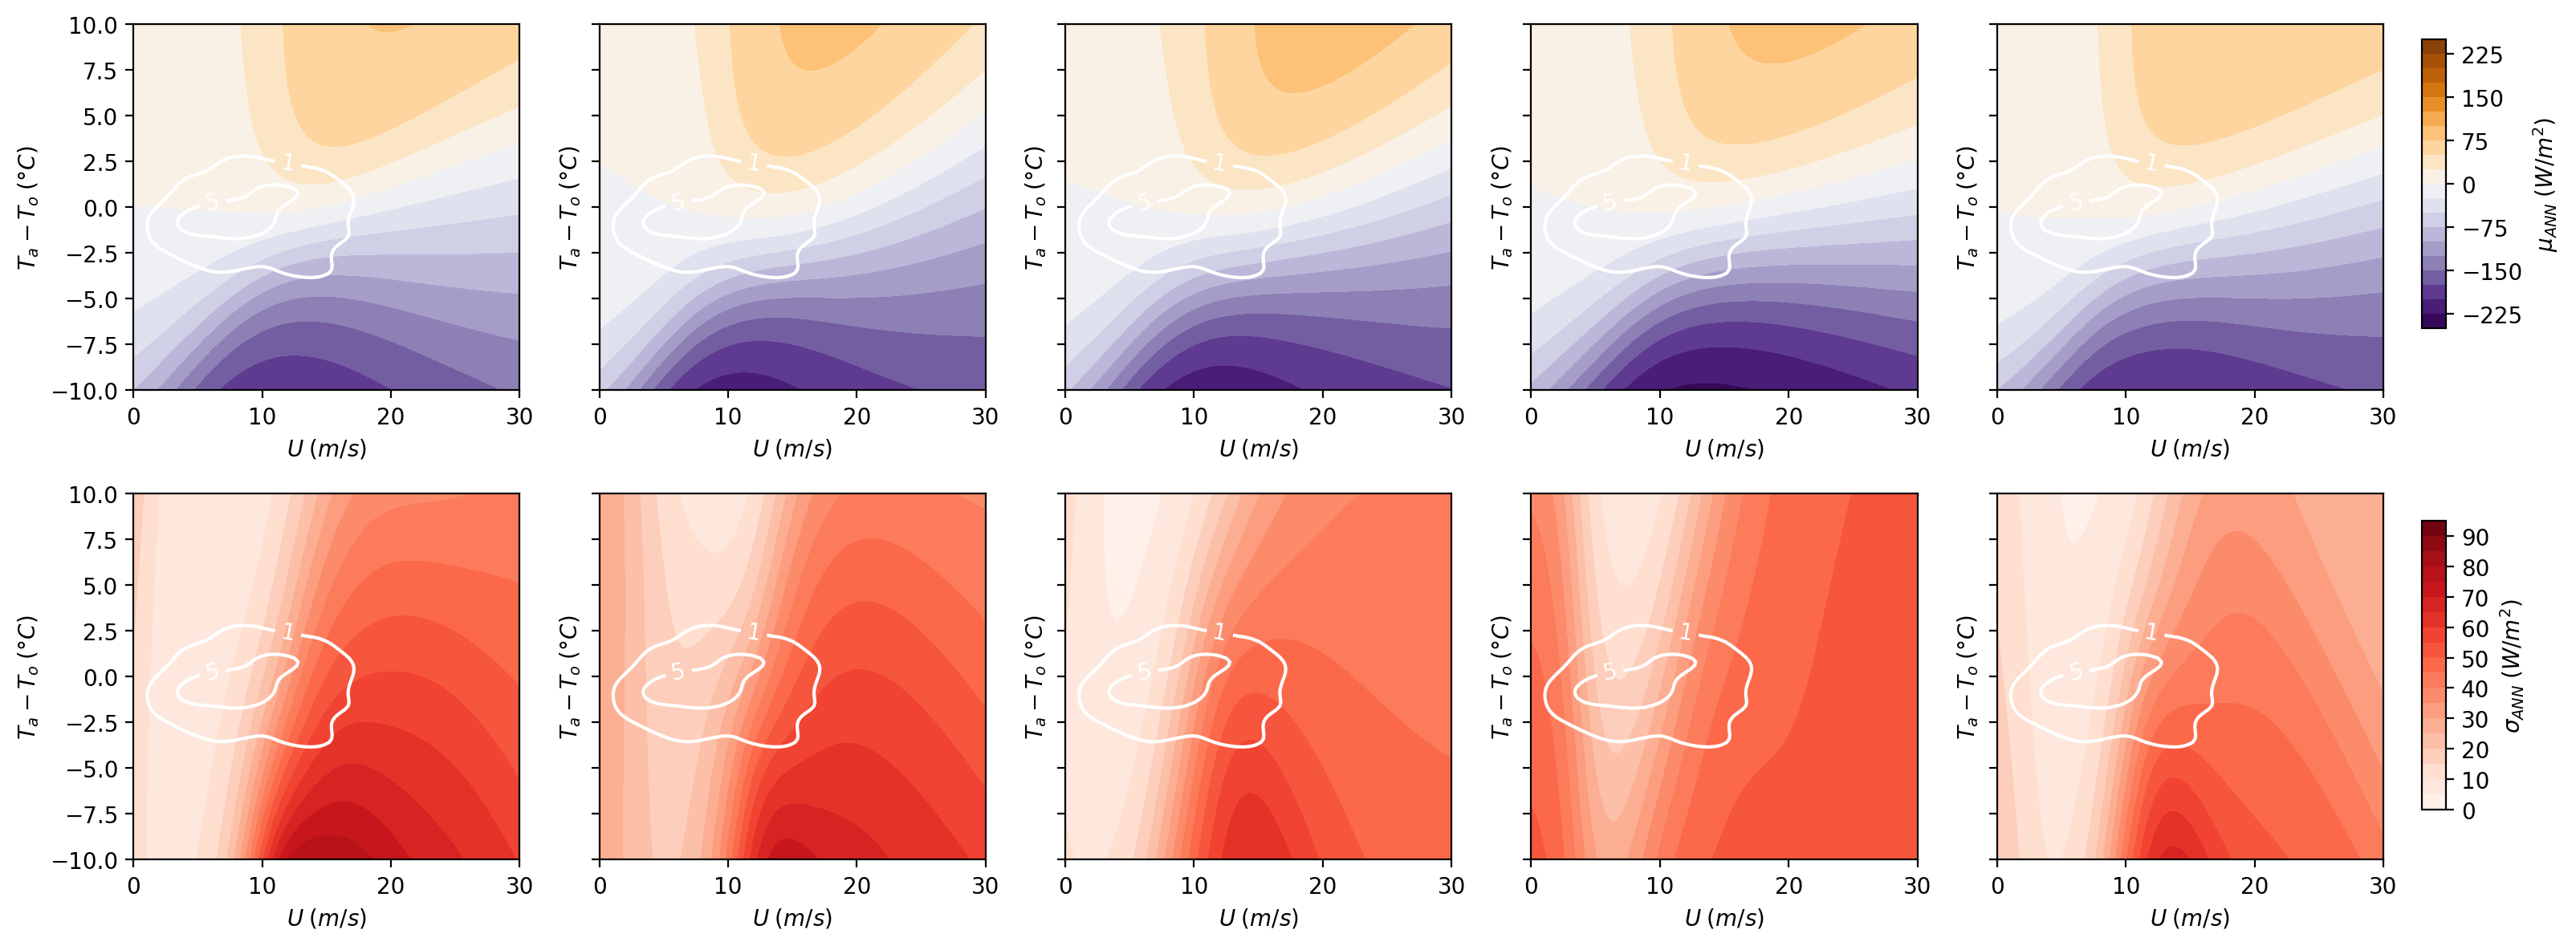

In [4]:
from mlflux.utils import qsat
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5_1step/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
fig, axes = plt.subplots(2, 5, figsize=[15,6], dpi=200, sharey=True)

std_2D_ensem = []
mean_2D_ensem = []
for rand_seed in range(5):
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)
    Xgrid, mean_grid, std_grid = gen_grid_U_dT (model)
    
    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    U = Xgrid[:,:,0]
    Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]

    ax = axes[0,rand_seed]
    img_mean = ax.contourf(U, Tdiff, mean_grid, levels=np.arange(-250,270,25), cmap='PuOr_r')
    # img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')
    ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
    ax.set_xlim([0,30]); ax.set_ylim([-10,10])
    mean_2D_ensem.append(mean_grid)
    plot_data_density_U_dT (ax, ds, Xgrid, model) 

    ax = axes[1,rand_seed]
    # img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
    img_std = ax.contourf(U, Tdiff, std_grid, levels=np.arange(0,100,5), cmap='Reds')
    ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
    ax.set_xlim([0,30]); ax.set_ylim([-10,10])
    std_2D_ensem.append(std_grid)
    plot_data_density_U_dT (ax, ds, Xgrid, model)        
       

cbar_ax0 = fig.add_axes([1, 0.65, 0.01, 0.3])  # [left, bottom, width, height]
cbar0 = fig.colorbar(img_mean, cax=cbar_ax0, label=r'$\mu_{ANN} \; (W/m^2)$')

cbar_ax1 = fig.add_axes([1, 0.15, 0.01, 0.3])  # [left, bottom, width, height]
cbar1 = fig.colorbar(img_std, cax=cbar_ax1, label=r'$\sigma_{ANN} \; (W/m^2)$')
plt.tight_layout();

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mlflux.ann import RealFluxDataset
from scipy.stats import gaussian_kde

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=4, alpha=0.2, edgecolors='none')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, density=True)
    ax_histy.hist(y, bins=bins, orientation='horizontal', density=True)

def density(ds, Xgrid, ax):
    #### Compute the density 
    vd = RealFluxDataset(ds, input_keys=model.config['ikeys'], 
                         output_keys=model.config['okeys'], bulk_keys=model.config['bkeys'])  
    kde = gaussian_kde(np.vstack([vd.X[:,0], vd.X[:,2]-vd.X[:,1]]), weights=None)  
    U = Xgrid[:,:,0]; Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
    zi = kde(np.vstack([U.flatten(), Tdiff.flatten()]))  # Evaluate KDE on the grid
    zi = zi.reshape(101, 201)*len(vd.X)  # Reshape to match grid, AND! convert density to counts
    
    #### Contourf of the density
    # ax.contourf(U, Tdiff, zi, levels=10)

    #### Contour lines 
    levels = (10, 100, 1000)
    contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='k')  # Filled contours
    ax.clabel(contour, inline=True, fontsize=10)

/state/partition1/job-57183924/ipykernel_2200415/2779557107.py:37: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='k')  # Filled contours


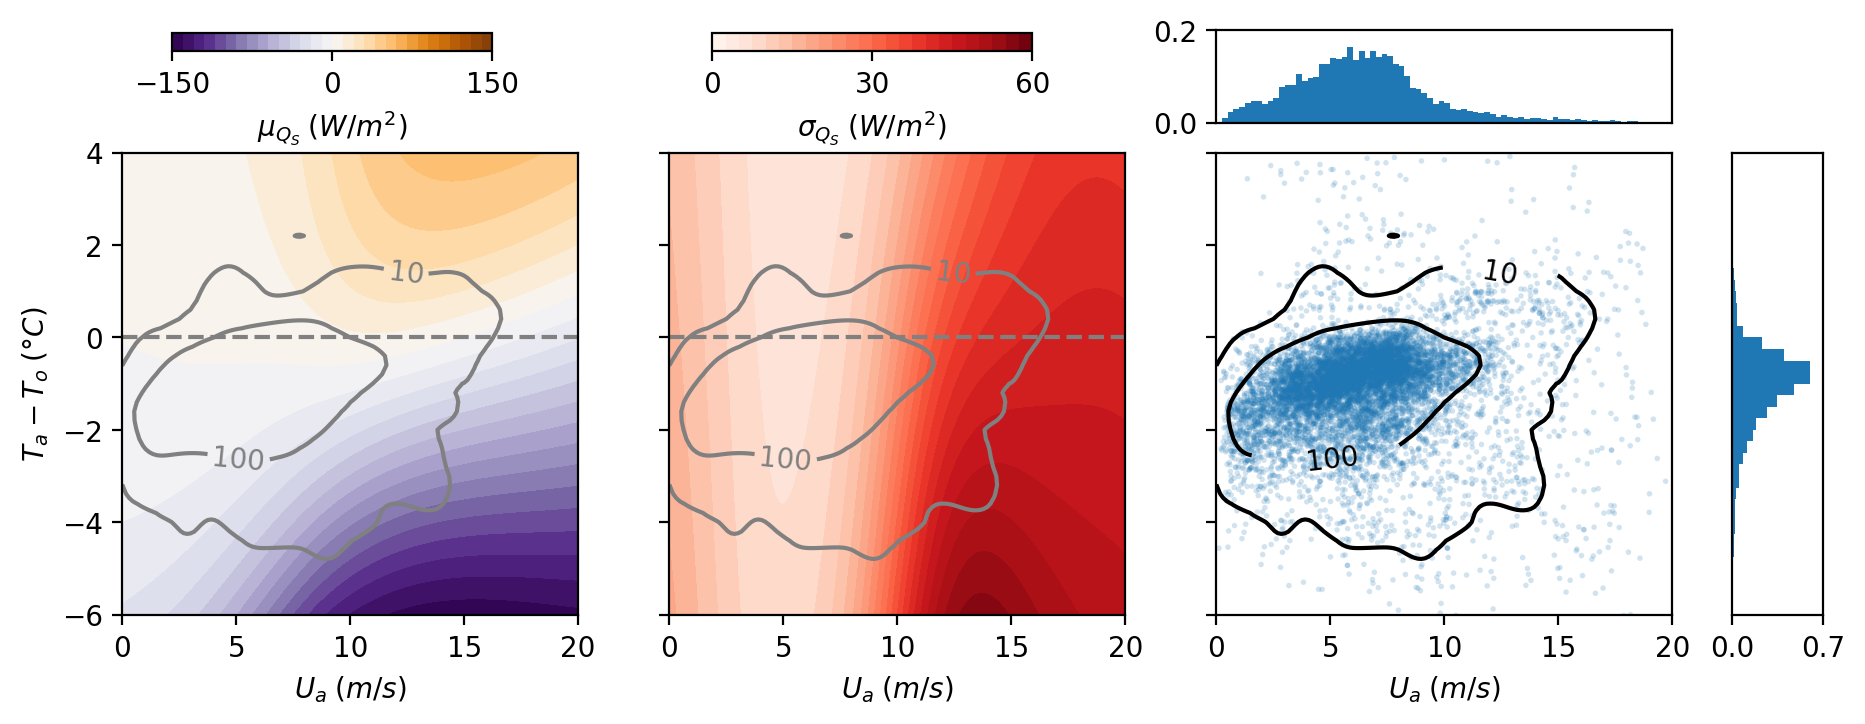

In [9]:
from mlflux.utils import qsat
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'

fig, axes = plt.subplots(1, 3, figsize=[10,3.], dpi=200, sharey=True)

rand_seed = 4
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name)
Xgrid, mean_grid, std_grid = gen_grid_U_dT (model)

ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
U = Xgrid[:,:,0]
Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
vd = RealFluxDataset(ds, input_keys=model.config['ikeys'], 
                     output_keys=model.config['okeys'], bulk_keys=model.config['bkeys'])

ax = axes[0]
img_mean = ax.contourf(U, Tdiff, mean_grid, levels=np.arange(-150,155,10), cmap='PuOr_r')
# img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')

cbar_ax1 = fig.add_axes([0.15, 1.05, 0.16, 0.03])  # [left, bottom, width, height]
cbar1 = fig.colorbar(img_mean, cax=cbar_ax1, orientation="horizontal", ticks=[-150,0,150])
cbar1.set_label(r'$\mu_{Q_S} \; (W/m^2)$')
# plt.colorbar(img_mean, label=r'$\mu_{Q_S} \; (W/m^2)$', ticks=[-150,-100,-50,0,50,100,150], orientation='horizontal', location='top')

ax.set_xlabel(r'$U_a \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,20]); ax.set_ylim([-6,4])
ax.axhline(y=0, color='gray', linestyle='--')
plot_data_density_U_dT (ax, ds, Xgrid, model) 

ax = axes[1]
# img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
img_std = ax.contourf(U, Tdiff, std_grid, levels=np.arange(0,61,2.5), cmap='Reds')

cbar_ax2 = fig.add_axes([0.42, 1.05, 0.16, 0.03])  # Adjust placement
cbar2 = fig.colorbar(img_std, cax=cbar_ax2, orientation="horizontal", ticks=[0,30,60])
cbar2.set_label(r'$\sigma_{Q_S} \; (W/m^2)$')

# plt.colorbar(img_std, label=r'$\sigma_{Q_S} \; (W/m^2)$', ticks=[0,20,40,60], orientation='horizontal', location='top')

ax.set_xlabel(r'$U_a \; (m/s)$') 
# ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,20]); ax.set_ylim([-6,4])
ax.axhline(y=0, color='gray', linestyle='--')
plot_data_density_U_dT (ax, ds, Xgrid, model)        
   
# Draw the scatter plot and marginals.
ax = axes[2]
pos = ax.get_position()
ax_histx = fig.add_axes([pos.x0, pos.y1 + 0.05, pos.width, 0.2 * pos.height], sharex=ax) # Manually place histogram axes **outside** the main subplot
ax_histy = fig.add_axes([pos.x1 + 0.03, pos.y0, 0.2 * pos.width, pos.height], sharey=ax)

# Remove extra labels for histograms
ax_histx.xaxis.set_visible(False)
ax_histy.yaxis.set_visible(False)

scatter_hist(vd.X[:,0].numpy(), (vd.X[:,2]-vd.X[:,1]).numpy(), ax, ax_histx, ax_histy)
density(ds, Xgrid, ax)

ax.set_xlabel(r'$U_a \; (m/s)$')
# ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,20])
ax.set_ylim([-6,4])
ax_histx.set_ylim([0,0.2]); ax_histx.set_yticks([0,0.2])
ax_histy.set_xlim([0,0.7]); ax_histy.set_xticks([0,0.7])

# plt.tight_layout()
fig.savefig(f'../../plots/structure_QS.png', bbox_inches='tight')

<xarray.DataArray 'zu' ()>
array(17.72419784)


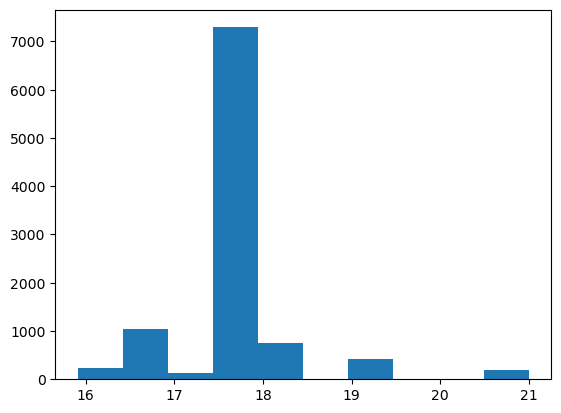

In [17]:
plt.hist(ds.zu.values)
print(ds.zu.mean())

<xarray.DataArray 'zt' ()>
array(15.35327413)


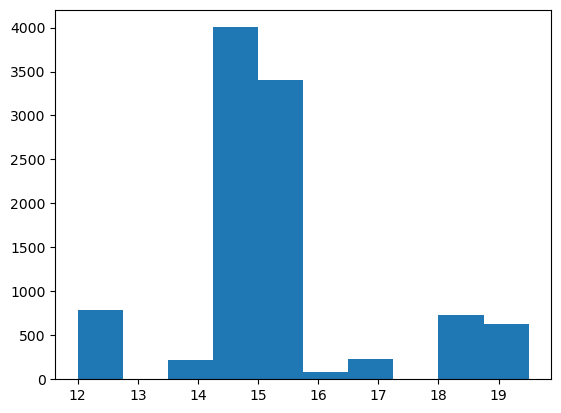

In [15]:
plt.hist(ds.zt.values)
print(ds.zt.mean())

### Difference between ANN and bulk

In [18]:
#### This requires the aerobulk function to be available

from aerobulk.flux import noskin 
from mlflux.utils import qsat

U = np.linspace(0,30,201)  # 1D array for U
Ta = np.linspace(0,20,101)  # 1D array for Ta
To = np.ones(101)*10 # 1D array for To
U_grid, Ta_grid = np.meshgrid(U, Ta)

''' Dependence: aerobulk-python
    https://github.com/jbusecke/aerobulk-python 
    Installation through conda works on Greene but not on MacBook yet.
    Update: use measured pressure instead of constant pressure!
'''
# hl, hs, taux, tauy, evap = noskin(sst=ds.tsea+273.15, t_zt=ds.tair+273.15, 
#                                   hum_zt=ds.qair, u_zu=ds.U, v_zu=ds.U*0, 
#                                   slp=ds.p, algo=algo, 
#                                   zt=ds.zt, zu=ds.zu)  
# ds = ds.assign(hlb=hl,hsb=hs,taubx=taux)

ds_grid = xr.Dataset(data_vars={    
                    'U':(['dt','u'], U_grid),
                    'Ta':(['dt','u'], Ta_grid),
                    'To':(['dt','u'], np.ones_like(Ta_grid) * 10),
                    'RH':(['dt','u'], np.ones_like(Ta_grid) * 80),
                    'p':(['dt','u'], np.ones_like(Ta_grid) * 101000),
                    'zu':(['dt','u'], np.ones_like(Ta_grid) * 18),
                    'zt':(['dt','u'], np.ones_like(Ta_grid) * 15),    
                },
               coords={
                   'u':(['u'], U),
                   'dt':(['dt'], Ta-10)
               })
ds_grid['q'] = qsat(ds_grid.Ta, ds_grid.p/100) * ds_grid.RH / 100 / 1000

In [19]:
%%time
hl, hs, taux, tauy, evap = noskin(sst=ds_grid.To+273.15, t_zt=ds_grid.Ta+273.15, 
                                  hum_zt=ds_grid.q, u_zu=ds_grid.U, v_zu=ds_grid.U*0, 
                                  slp=ds_grid.p, algo='coare3p0', 
                                  zt=ds_grid.zt, zu=ds_grid.zu)

/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


CPU times: user 84.4 ms, sys: 1.98 ms, total: 86.4 ms
Wall time: 317 ms


In [20]:
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
rand_seed = 4
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name)

U = np.linspace(0,30,201)  # 1D array for U
Ta = np.linspace(0,20,101)  # 1D array for Ta
To = np.ones(101)*10 # 1D array for To
U_grid, Ta_grid = np.meshgrid(U, Ta)
U_flat = U_grid.flatten().reshape(-1, 1)  # Flatten to 2D column
Ta_flat = Ta_grid.flatten().reshape(-1, 1)  # Flatten to 2D column
To_flat = np.ones_like(U_flat) * 10    
zu_flat = np.ones_like(U_flat) * 10
zt_flat = np.ones_like(U_flat) * 5
RH_flat = np.ones_like(U_flat) * 80
p_flat = np.ones_like(U_flat) * 101000

if model.config['ikeys'] == ["U", "tsea", "tair", "zu", "zt"]:
    X = np.hstack([U_flat,To_flat,Ta_flat,zu_flat,zt_flat]).astype('float32')
elif model.config['ikeys'] == ["U", "tsea", "tair", "rh"]:
    X = np.hstack([U_flat,To_flat,Ta_flat,RH_flat]).astype('float32')  
elif model.config['ikeys'] == ["U", "tsea", "tair", "rh", "p"]:
    X = np.hstack([U_flat,To_flat,Ta_flat,RH_flat,p_flat]).astype('float32')

In [21]:
%%time

mean_pred = model.pred_mean(torch.tensor(X)).detach().numpy()
mean_2D = mean_pred.reshape(101, 201)

CPU times: user 4.25 ms, sys: 23 µs, total: 4.28 ms
Wall time: 4.31 ms


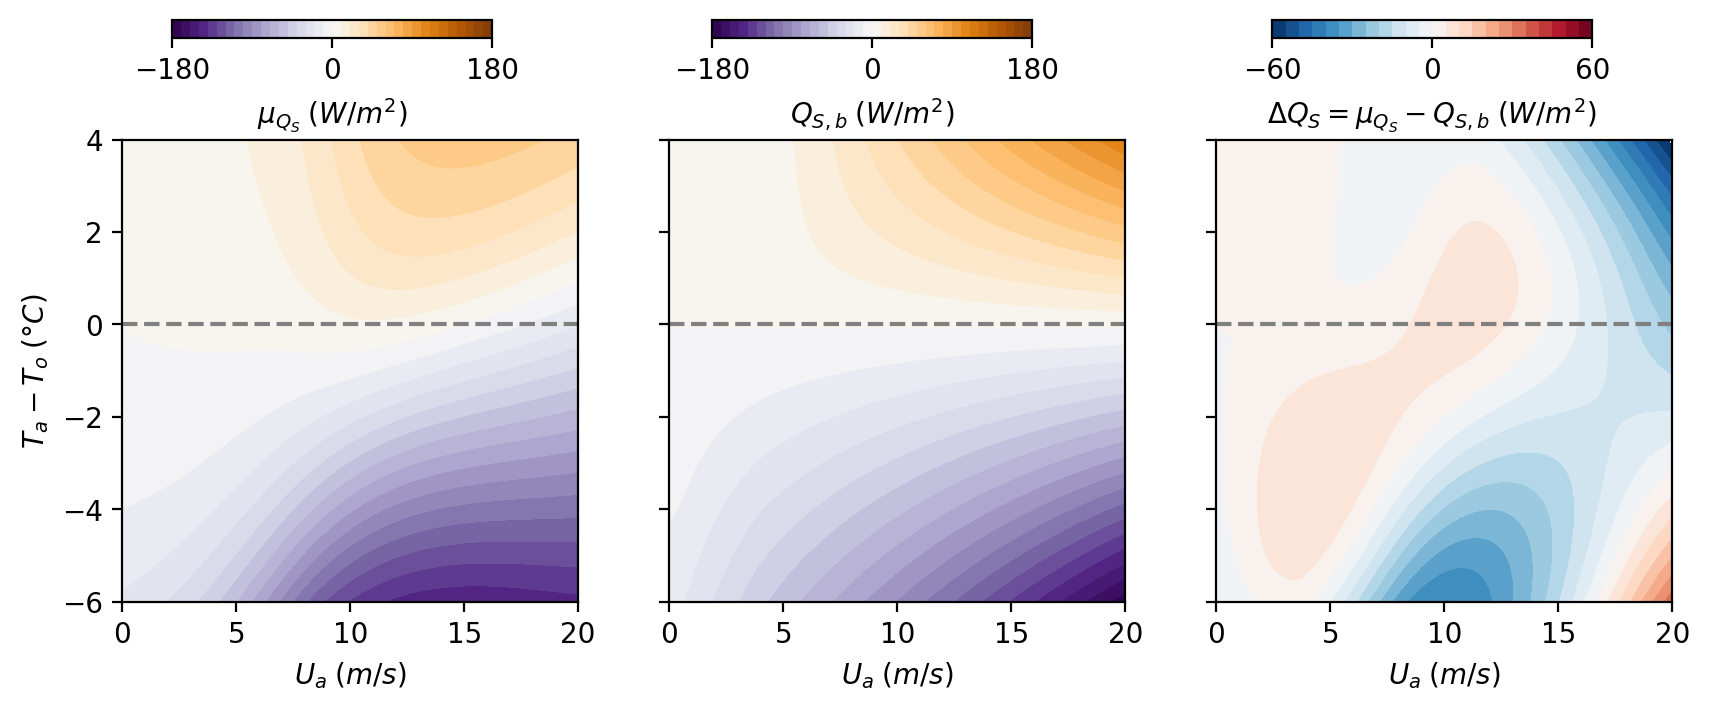

In [31]:
fig, axes = plt.subplots(1, 3, figsize=[10,3.], dpi=200, sharey=True)

ax = axes[0]
img_mean = ax.contourf(ds_grid.U.values, ds_grid.Ta.values - ds_grid.To.values, mean_2D, 
                       levels=np.arange(-180,185,10), cmap='PuOr_r')

cbar_ax1 = fig.add_axes([0.15, 1.05, 0.16, 0.03])  # [left, bottom, width, height]
cbar1 = fig.colorbar(img_mean, cax=cbar_ax1, orientation="horizontal", ticks=[-180,0,180])
cbar1.set_label(r'$\mu_{Q_S} \; (W/m^2)$')

ax.set_xlabel(r'$U_a \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,20]); ax.set_ylim([-6,4])
ax.axhline(y=0, color='gray', linestyle='--')


ax = axes[1]
img_mean = ax.contourf(ds_grid.U.values, ds_grid.Ta.values - ds_grid.To.values, hs.values, 
                       levels=np.arange(-180,185,10), cmap='PuOr_r')

cbar_ax2 = fig.add_axes([0.42, 1.05, 0.16, 0.03])  # Adjust placement
cbar2 = fig.colorbar(img_mean, cax=cbar_ax2, orientation="horizontal", ticks=[-180,0,180])
cbar2.set_label(r'$Q_{S,b} \; (W/m^2)$')

ax.set_xlabel(r'$U_a \; (m/s)$')
ax.set_xlim([0,20]); ax.set_ylim([-6,4])
ax.axhline(y=0, color='gray', linestyle='--')

ax = axes[2]
img_diff = ax.contourf(ds_grid.U.values, ds_grid.Ta.values - ds_grid.To.values, mean_2D - hs.values, 
                       levels=np.arange(-60,65,5), cmap='RdBu_r')

cbar_ax3 = fig.add_axes([0.7, 1.05, 0.16, 0.03])  # Adjust placement
cbar3 = fig.colorbar(img_diff, cax=cbar_ax3, orientation="horizontal", ticks=[-60,0,60])
cbar3.set_label(r'${\Delta Q_S} = \mu_{Q_S} - Q_{S,b}  \; (W/m^2)$')

ax.set_xlabel(r'$U_a \; (m/s)$')
ax.set_xlim([0,20]); ax.set_ylim([-6,4])
ax.axhline(y=0, color='gray', linestyle='--')

# plt.tight_layout()
fig.savefig(f'../../plots/structure_QS_diff.pdf', bbox_inches='tight')

### Check density plot

/state/partition1/job-57108285/ipykernel_3135252/455150426.py:37: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='k')  # Filled contours


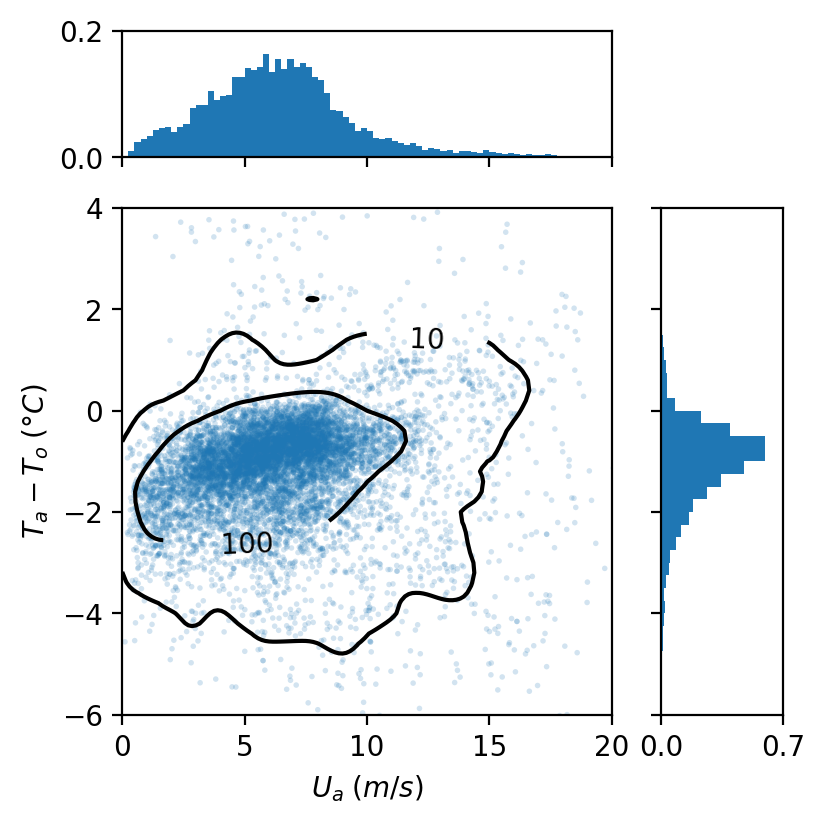

In [112]:
# Create a Figure, which doesn't have to be square.
fig = plt.figure(layout='constrained', figsize=[4,4], dpi=200)
# Create the main Axes, leaving 25% of the figure space at the top and on the
# right to position marginals.

ax = fig.add_gridspec(top=0.75, right=0.75).subplots()

ax_histx = ax.inset_axes([0, 1.1, 1, 0.25], sharex=ax) 
ax_histy = ax.inset_axes([1.1, 0, 0.25, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(vd.X[:,0].numpy(), (vd.X[:,2]-vd.X[:,1]).numpy(), ax, ax_histx, ax_histy)
density(ds, Xgrid, ax)
ax.set_xlabel(r'$U_a \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')

ax.set_xlim([0,20])
ax.set_ylim([-6,4])
ax_histx.set_ylim([0,0.2]); ax_histx.set_yticks([0,0.2])
ax_histy.set_xlim([0,0.7]); ax_histy.set_xticks([0,0.7])
plt.show()

/state/partition1/job-57108285/ipykernel_3135252/251071930.py:42: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='k')  # Filled contours


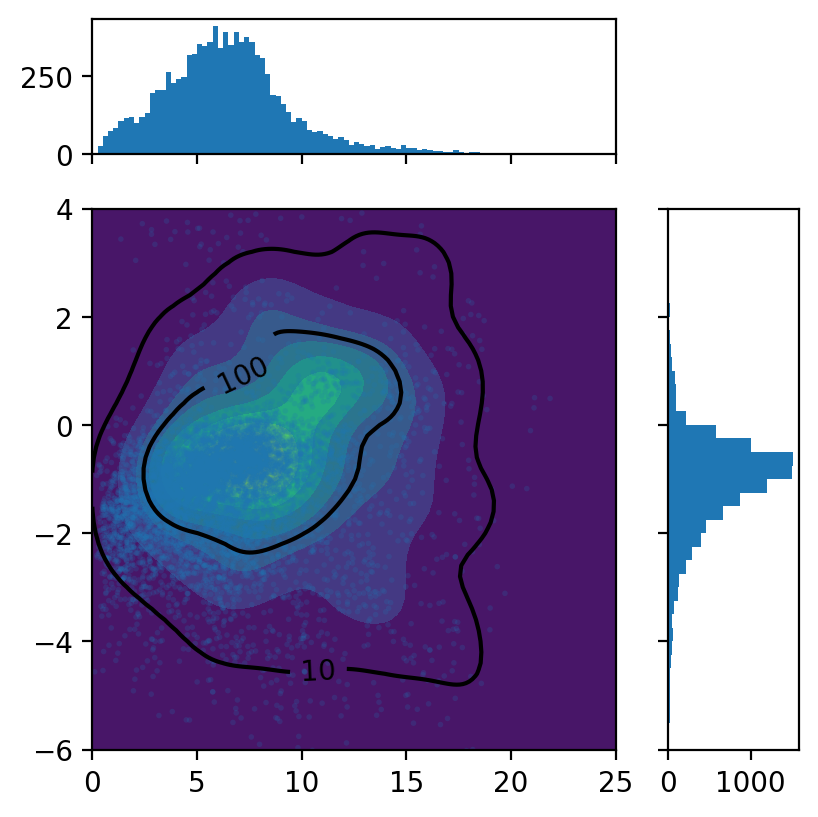

In [98]:
# Weighted (with the weights from Papa)

# w_index = np.random.choice(len(vd.X), 10000, p=vd.W.squeeze()/vd.W.sum())
# kde = gaussian_kde(np.vstack([vd.X[w_index,0], vd.X[w_index,2]-vd.X[w_index,1]]))
kde = gaussian_kde(np.vstack([vd.X[:,0], vd.X[:,2]-vd.X[:,1]]), weights=vd.W[:,0])  
# kde = gaussian_kde(np.vstack([vd.X[:,0], vd.X[:,2]-vd.X[:,1]]), weights=None)  

# Create a Figure, which doesn't have to be square.
fig = plt.figure(layout='constrained', figsize=[4,4], dpi=200)
# Create the main Axes, leaving 25% of the figure space at the top and on the
# right to position marginals.
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()

U = Xgrid[:,:,0]; Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
zi = kde(np.vstack([U.flatten(), Tdiff.flatten()]))  # Evaluate KDE on the grid
zi = zi.reshape(101, 201)*len(vd.X)  # Reshape to match grid, AND! convert density to counts

ax.contourf(U, Tdiff, zi, levels=10)
levels = (10, 100)
contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='k')  # Filled contours
ax.clabel(contour, inline=True, fontsize=10)

# Add axis
ax_histx = ax.inset_axes([0, 1.1, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.1, 0, 0.25, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(vd.X[:,0].numpy(), (vd.X[:,2]-vd.X[:,1]).numpy(), ax, ax_histx, ax_histy)

ax.set_xlim([0,25])
ax.set_ylim([-6,4])
plt.show()

In [85]:
U = Xgrid[:,:,0]; Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
zi = kde(np.vstack([U.flatten(), Tdiff.flatten()]))  # Evaluate KDE on the grid
zi.sum()*(U[0,1]-U[0,0])*(Tdiff[1,0]-Tdiff[0,0])

0.9970322136997759

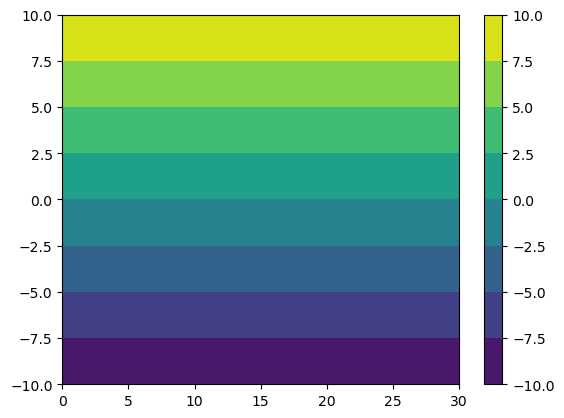

In [60]:
kde = gaussian_kde(np.vstack([vd.X[:,2]-vd.X[:,1], vd.X[:,0]]), weights=vd.W[:,0])
U = Xgrid[:,:,0]; Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
plt.contourf(U,Tdiff,Tdiff)
plt.colorbar()

### Momentum flux

/scratch/jw8736/mlflux/notebooks/regression/probes.py:78: UserWarning: The following kwargs were not used by contour: 'fill'


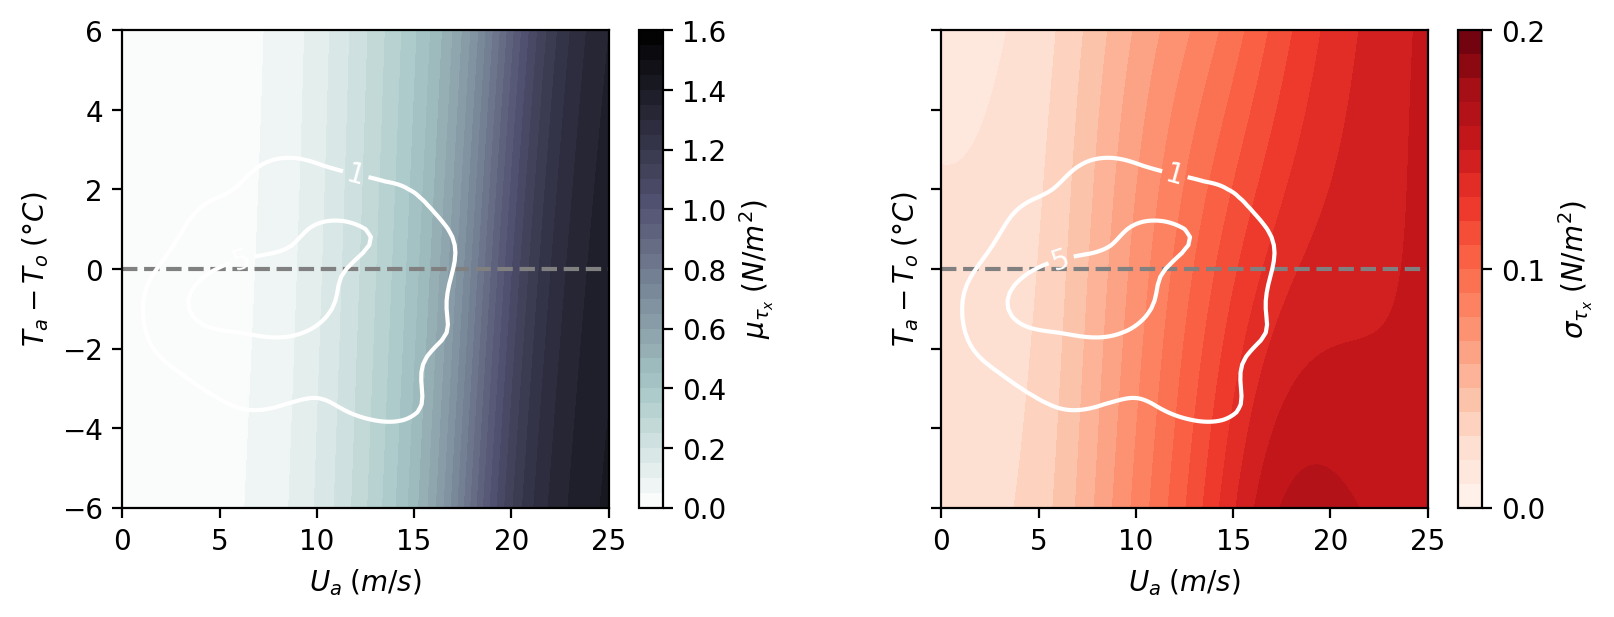

In [45]:
from mlflux.utils import qsat
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'

fig, axes = plt.subplots(1, 2, figsize=[9,4], dpi=200, sharey=True)

rand_seed = 4
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name)
Xgrid, mean_grid, std_grid = gen_grid_U_dT (model)

ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
U = Xgrid[:,:,0]
Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]

ax = axes[0]
img_mean = ax.contourf(U, Tdiff, mean_grid, levels=np.arange(0,1.65,0.05), cmap='bone_r')
# img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')
plt.colorbar(img_mean, label=r'$\mu_{\tau_x} \; (N/m^2)$', ticks=[0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6])
ax.set_xlabel(r'$U_a \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,25]); ax.set_ylim([-6,6])
ax.axhline(y=0, color='gray', linestyle='--')
plot_data_density (ax, ds, Xgrid, model) 

ax = axes[1]
# img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
img_std = ax.contourf(U, Tdiff, std_grid, levels=np.arange(0,0.21,0.01), cmap='Reds')
plt.colorbar(img_std, label=r'$\sigma_{\tau_x} \; (N/m^2)$', ticks=[0,0.1,0.2])
ax.set_xlabel(r'$U_a \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,25]); ax.set_ylim([-6,6])
ax.axhline(y=0, color='gray', linestyle='--')
plot_data_density (ax, ds, Xgrid, model)        
   
plt.tight_layout(pad=4)
fig.savefig(f'../../plots/structure_taux.png', bbox_inches='tight')

/scratch/jw8736/mlflux/notebooks/regression/probes.py:78: UserWarning: The following kwargs were not used by contour: 'fill'


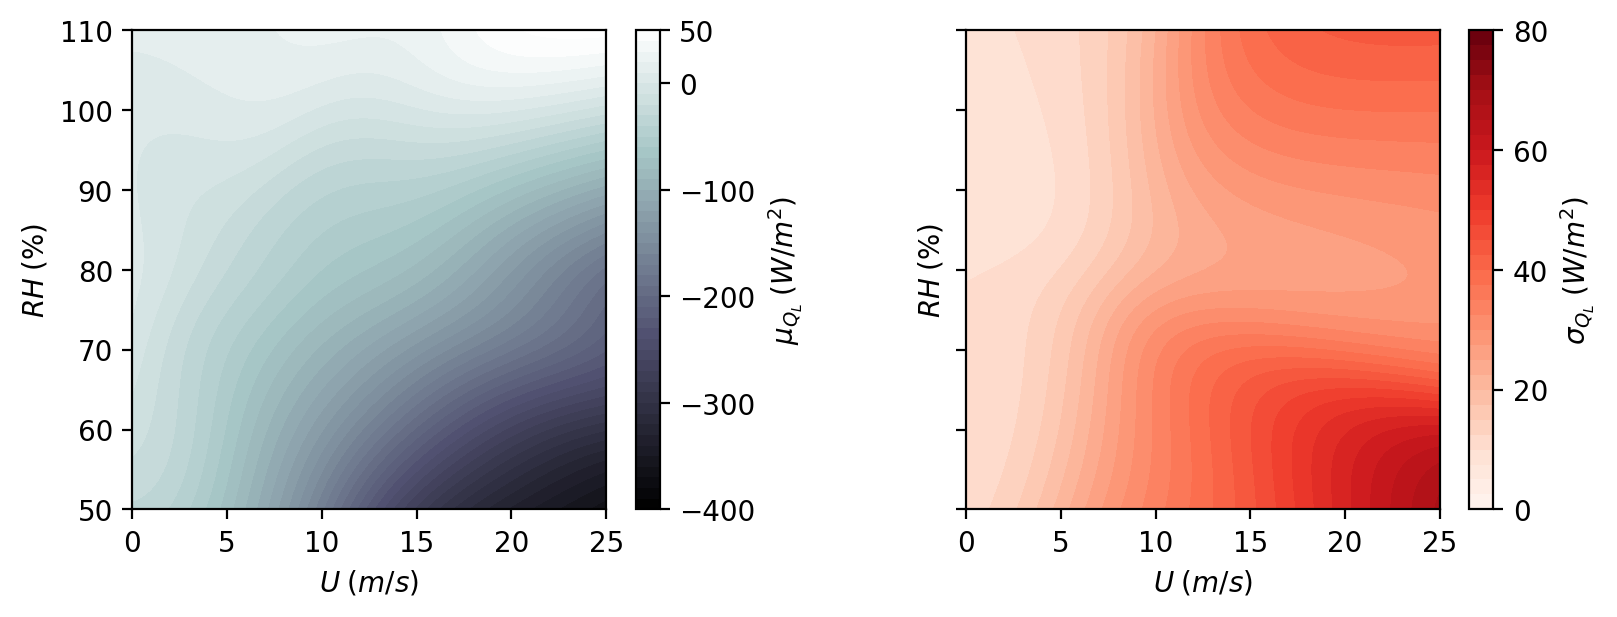

In [39]:
from mlflux.utils import qsat
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'

fig, axes = plt.subplots(1, 2, figsize=[9,4], dpi=200, sharey=True)

rand_seed = 4
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name)
Xgrid, mean_grid, std_grid = gen_grid_U_RH (model)

ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
U = Xgrid[:,:,0]
RH = Xgrid[:,:,3]

ax = axes[0]
img_mean = ax.contourf(U, RH, mean_grid, levels=np.arange(-400,55,10), cmap='bone')
# img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')
plt.colorbar(img_mean, label=r'$\mu_{Q_L} \; (W/m^2)$', ticks=[-400,-300,-200,-100,0,50])
ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$RH \; (\%)$')
ax.set_xlim([0,25]); ax.set_ylim([50,110])
ax.axhline(y=0, color='gray', linestyle='--')
plot_data_density_U_RH (ax, ds, Xgrid, model) 

ax = axes[1]
# img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
img_std = ax.contourf(U, RH, std_grid, levels=np.arange(0,81,2.5), cmap='Reds')
plt.colorbar(img_std, label=r'$\sigma_{Q_L} \; (W/m^2)$', ticks=[0,20,40,60,80])
ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$RH \; (\%)$')
ax.set_xlim([0,25]); ax.set_ylim([50,110])
ax.axhline(y=0, color='gray', linestyle='--')
plot_data_density_U_RH (ax, ds, Xgrid, model)        
   
plt.tight_layout(pad=4)
fig.savefig(f'../../plots/structure_QL.png', bbox_inches='tight')

### Mean of ensemble of ANNs

/state/partition1/job-52435259/ipykernel_2025790/1476758937.py:46: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours


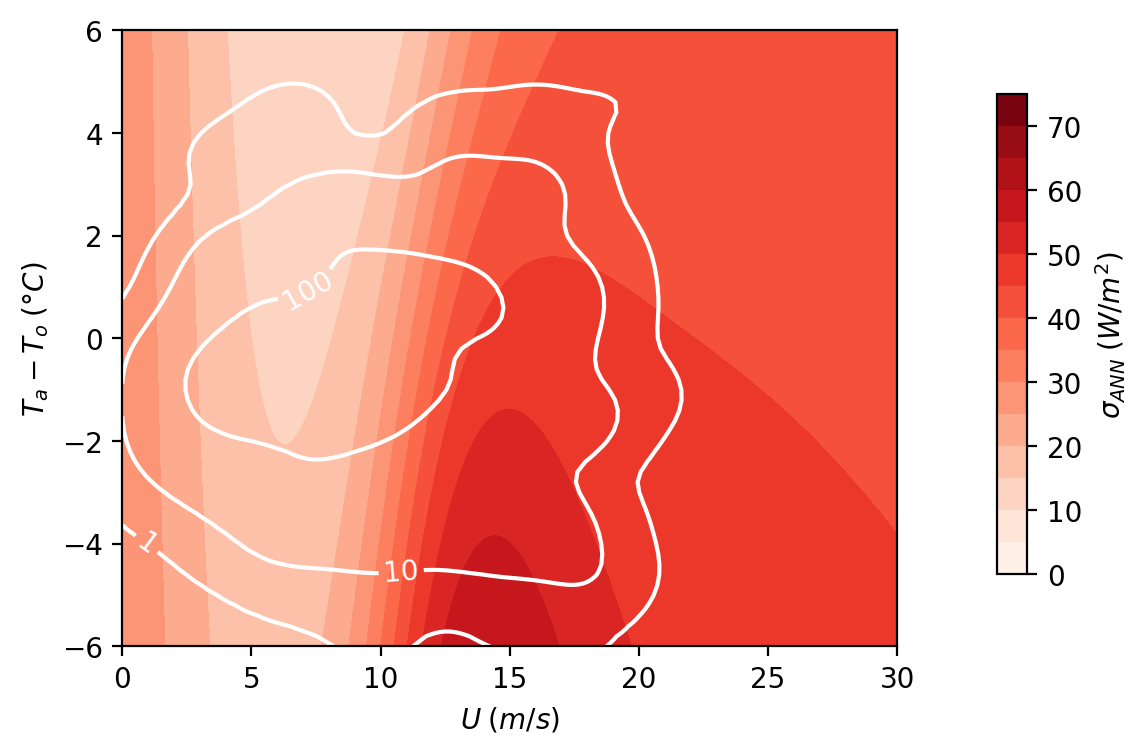

In [4]:
fig = plt.figure(figsize=[5,4], dpi=200); ax = plt.gca()

U = Xgrid[:,:,0]
Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
std_ensem = np.array(std_2D_ensem).mean(axis=0)
img = plt.contourf(U, Tdiff, std_ensem, levels=np.arange(0,80,5), cmap='Reds')
ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,30]); ax.set_ylim([-6,6])
        
plot_data_density (ax, ds, Xgrid)
cbar_ax = fig.add_axes([1, 0.2, 0.03, 0.6])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, label=r'$\sigma_{ANN}\; (W/m^2)$')

In [ ]:
from mlflux.utils import qsat
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5_1step/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5/'
model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
fig, axes = plt.subplots(1, 5, figsize=[15,3], dpi=200, sharey=True)

std_2D_ensem = []
for rand_seed in range(5):
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)
    ax = axes[rand_seed]
    Xgrid, std_grid = gen_grid (model)

    U = Xgrid[:,:,0]
    RH = Xgrid[:,:,4] 
    img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
    # img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')
    ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
    ax.set_xlim([0,30]); ax.set_ylim([-10,10])
    std_2D_ensem.append(std_grid)
        
    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    plot_data_density (ax, ds, Xgrid)

cbar_ax = fig.add_axes([1, 0.2, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, label=r'$\log(\sigma_{ANN}) \; (W/m^2)$')
plt.tight_layout();